## Librerías

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import warnings

# Suprimir advertencias para una salida más limpia
warnings.filterwarnings('ignore')

## Cargar datasets

In [2]:
def load_iris_data():
    """Carga y prepara el dataset iris.csv"""
    try:
        data = pd.read_csv('iris.csv', header=0)
        X = data.iloc[:, :-1]
        y = data.iloc[:, -1]
        return X, y, list(y.unique())
    except FileNotFoundError:
        print("Error: 'iris.csv' no encontrado. Asegúrate de que esté en el mismo directorio.")
        return None, None, None
    except Exception as e:
        print(f"Error al leer 'iris.csv': {e}")
        return None, None, None

In [3]:
def load_emails_data():
    """Carga y prepara el dataset emails.csv"""
    try:
        data = pd.read_csv('emails.csv')
        X = data.iloc[:, 1:-1]
        y = data.iloc[:, -1]
        target_names = ['No Spam (0)', 'Spam (1)']
        return X, y, target_names
    except FileNotFoundError:
        print("Error: 'emails.csv' no encontrado. Asegúrate de que esté en el mismo directorio.")
        return None, None, None
    except Exception as e:
        print(f"Error al leer 'emails.csv': {e}")
        return None, None, None

## Procesar el dataset

In [4]:
def process_dataset(dataset_name, load_function):
    """Proceso completo para un dataset"""
    print(f"\n{'=' * 70}")
    print(f"Procesando Dataset: {dataset_name}")
    print(f"{'=' * 70}")
    
    X, y, target_names = load_function()
    if X is None:
        return (None, None), None

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=0
    )

    print(f"\nDatos cargados correctamente:")
    print(f"   - Total de instancias: {X.shape[0]}")
    print(f"   - Entrenamiento (70%): {X_train.shape[0]}")
    print(f"   - Prueba (30%): {X_test.shape[0]}")

    # --- Etapa de Entrenamiento y Validación (para Tabla 1) ---
    print("\nEtapa 1: Validación Cruzada (k=3)")
    
    models = {'Normal': GaussianNB(), 'Multinomial': MultinomialNB()}
    kf = KFold(n_splits=3)
    
    cv_results = {}
    
    for model_name, model in models.items():
        fold_accuracies = []
        print(f"\nEvaluando modelo: {model_name}")
        for fold, (train_index, val_index) in enumerate(kf.split(X_train, y_train), start=1):
            X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
            y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
            
            model.fit(X_train_fold, y_train_fold)
            y_pred_val = model.predict(X_val_fold)
            acc = accuracy_score(y_val_fold, y_pred_val)
            fold_accuracies.append(acc)
            print(f"   • Pliegue {fold}: Accuracy = {acc:.4f}")
        
        avg_acc = np.mean(fold_accuracies)
        print(f"   → Promedio de accuracy ({model_name}): {avg_acc:.4f}")
        
        cv_results[model_name] = {
            '1': fold_accuracies[0],
            '2': fold_accuracies[1],
            '3': fold_accuracies[2],
            'Promedio': avg_acc
        }

    # --- Etapa de Pruebas (para Tabla 2 y Reportes) ---
    print("\nEtapa 2: Pruebas Finales")
    
    best_model_name = max(cv_results, key=lambda k: cv_results[k]['Promedio'])
    print(f"\nMejor modelo seleccionado: {best_model_name} (según promedio de validación)")

    best_model = GaussianNB() if best_model_name == 'Normal' else MultinomialNB()
    best_model.fit(X_train, y_train)
    
    y_pred_test = best_model.predict(X_test)
    final_accuracy = accuracy_score(y_test, y_pred_test)
    
    final_test_result = {
        'Dataset': dataset_name,
        'Distribución': best_model_name,
        'Accuracy': final_accuracy
    }

    print(f"\nAccuracy final en conjunto de prueba: {final_accuracy:.4f}")
    print(f"\nReporte de Clasificación Final ({dataset_name} - {best_model_name}):")
    print("=" * 70)
    print(classification_report(y_test, y_pred_test, target_names=target_names))
    
    print(f"\nMatriz de Confusión ({dataset_name} - {best_model_name}):")
    print("-" * 70)
    cm = confusion_matrix(y_test, y_pred_test)
    print(cm)
    
    try:
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
        disp.plot(cmap=plt.cm.Blues)
        plt.title(f'Matriz de Confusión - {dataset_name} ({best_model_name})')
        plt.show()
    except Exception as e:
        print(f"Advertencia: No se pudo mostrar la matriz de confusión gráfica. {e}")

    print(f"{'-' * 70}")
    
    return cv_results, final_test_result

In [5]:
tabla_1_data = {}
tabla_2_data = []

### Procesar Iris


Procesando Dataset: iris.csv

Datos cargados correctamente:
   - Total de instancias: 150
   - Entrenamiento (70%): 105
   - Prueba (30%): 45

Etapa 1: Validación Cruzada (k=3)

Evaluando modelo: Normal
   • Pliegue 1: Accuracy = 0.9143
   • Pliegue 2: Accuracy = 1.0000
   • Pliegue 3: Accuracy = 0.9429
   → Promedio de accuracy (Normal): 0.9524

Evaluando modelo: Multinomial
   • Pliegue 1: Accuracy = 0.6000
   • Pliegue 2: Accuracy = 0.9429
   • Pliegue 3: Accuracy = 0.6286
   → Promedio de accuracy (Multinomial): 0.7238

Etapa 2: Pruebas Finales

Mejor modelo seleccionado: Normal (según promedio de validación)

Accuracy final en conjunto de prueba: 1.0000

Reporte de Clasificación Final (iris.csv - Normal):
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        16
Iris-versicolor       1.00      1.00      1.00        18
 Iris-virginica       1.00      1.00      1.00        11

       accuracy                           1.00   

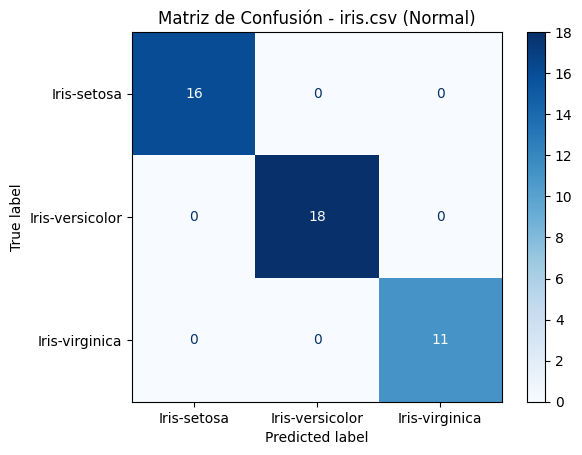

----------------------------------------------------------------------


In [6]:
cv_iris, test_iris = process_dataset('iris.csv', load_iris_data)
if cv_iris:
    tabla_1_data['iris.csv'] = cv_iris
if test_iris:
    tabla_2_data.append(test_iris)

### Procesar Emails


Procesando Dataset: emails.csv

Datos cargados correctamente:
   - Total de instancias: 5172
   - Entrenamiento (70%): 3620
   - Prueba (30%): 1552

Etapa 1: Validación Cruzada (k=3)

Evaluando modelo: Normal
   • Pliegue 1: Accuracy = 0.9478
   • Pliegue 2: Accuracy = 0.9428
   • Pliegue 3: Accuracy = 0.9494
   → Promedio de accuracy (Normal): 0.9467

Evaluando modelo: Multinomial
   • Pliegue 1: Accuracy = 0.9453
   • Pliegue 2: Accuracy = 0.9379
   • Pliegue 3: Accuracy = 0.9469
   → Promedio de accuracy (Multinomial): 0.9434

Etapa 2: Pruebas Finales

Mejor modelo seleccionado: Normal (según promedio de validación)

Accuracy final en conjunto de prueba: 0.9485

Reporte de Clasificación Final (emails.csv - Normal):
              precision    recall  f1-score   support

 No Spam (0)       0.98      0.95      0.96      1111
    Spam (1)       0.88      0.95      0.91       441

    accuracy                           0.95      1552
   macro avg       0.93      0.95      0.94      1552

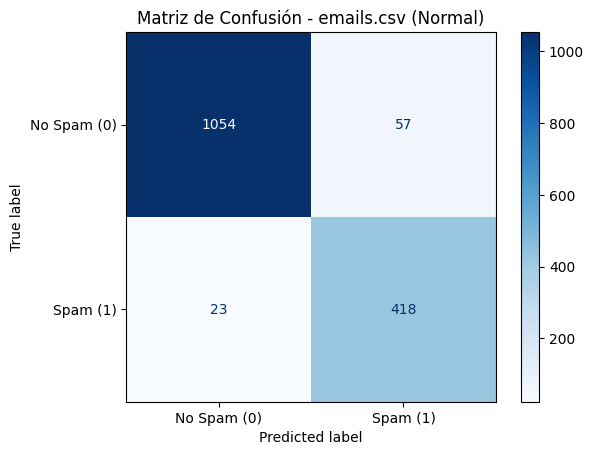

----------------------------------------------------------------------


In [7]:
cv_emails, test_emails = process_dataset('emails.csv', load_emails_data)
if cv_emails:
    tabla_1_data['emails.csv'] = cv_emails
if test_emails:
    tabla_2_data.append(test_emails)

### Tabla 1: Resultados Cross-Validation

In [8]:
print("\nTabla 1. Resultados de la validación cruzada con 3 pliegues (Entrenamiento)\n")

tabla_1_rows = []
for dataset, models in tabla_1_data.items():
    if models:
        for model_name, results in models.items():
            tabla_1_rows.append((dataset, model_name, '1', results['1']))
            tabla_1_rows.append((dataset, model_name, '2', results['2']))
            tabla_1_rows.append((dataset, model_name, '3', results['3']))
            tabla_1_rows.append((dataset, model_name, 'Promedio', results['Promedio']))
        
if tabla_1_rows:
    df_tabla1 = pd.DataFrame(tabla_1_rows, columns=['Dataset', 'Distribución', 'Pliegue', 'Accuracy'])
    df_tabla1 = df_tabla1.set_index(['Dataset', 'Distribución', 'Pliegue'])
    print(df_tabla1.to_string(float_format=lambda x: f"{x:.4f}"))
else:
    print("No se generaron datos para la Tabla 1.")


Tabla 1. Resultados de la validación cruzada con 3 pliegues (Entrenamiento)

                                  Accuracy
Dataset    Distribución Pliegue           
iris.csv   Normal       1           0.9143
                        2           1.0000
                        3           0.9429
                        Promedio    0.9524
           Multinomial  1           0.6000
                        2           0.9429
                        3           0.6286
                        Promedio    0.7238
emails.csv Normal       1           0.9478
                        2           0.9428
                        3           0.9494
                        Promedio    0.9467
           Multinomial  1           0.9453
                        2           0.9379
                        3           0.9469
                        Promedio    0.9434


### Tabla 2: Resultados finales

In [9]:
print("\nTabla 2. Resultados de las pruebas finales (Etapa de Pruebas)\n")
if tabla_2_data:
    df_tabla2 = pd.DataFrame(tabla_2_data, columns=['Dataset', 'Distribución', 'Accuracy'])
    df_tabla2 = df_tabla2.set_index('Dataset')
    print(df_tabla2.to_string(float_format=lambda x: f"{x:.4f}"))
else:
    print("No se generaron datos para la Tabla 2.")


Tabla 2. Resultados de las pruebas finales (Etapa de Pruebas)

           Distribución  Accuracy
Dataset                          
iris.csv         Normal    1.0000
emails.csv       Normal    0.9485
